Running MCTS experiments...

Running depth=15, iterations=100, num_rollouts=1 experiment (5 trials)...
Trial 1/5, Target: RRLRLRRRRR...
Trial 2/5, Target: LRLLRRLLRR...
Trial 3/5, Target: LRRRLLLRRR...
Trial 4/5, Target: RLRRLRRRLR...
Trial 5/5, Target: RLLLLRRRLL...

Results for depth=15, iterations=100, num_rollouts=1:
c          Efficiency Eff. Std   Effectiveness   Eff. Std   Avg Visited    
--------------------------------------------------------------------------------
0.50       0.000952 0.000246 0.5128 0.2046 62.4
1.00       0.001175 0.000293 0.6069 0.2027 77.0
1.41       0.001157 0.000278 0.6892 0.3104 75.8
2.00       0.001541 0.000000 0.2696 0.0489 101.0
3.00       0.001541 0.000000 0.1402 0.1130 101.0

Plot saved as 'mcts_results_r1.png'

Running depth=15, iterations=100, num_rollouts=5 experiment (5 trials)...
Trial 1/5, Target: RLLRLLLLRL...
Trial 2/5, Target: RRRLRRRRLL...
Trial 3/5, Target: LRRLRLRLRR...
Trial 4/5, Target: RRRLRLRRRR...
Trial 5/5, Target: LRRRRRRLLL...



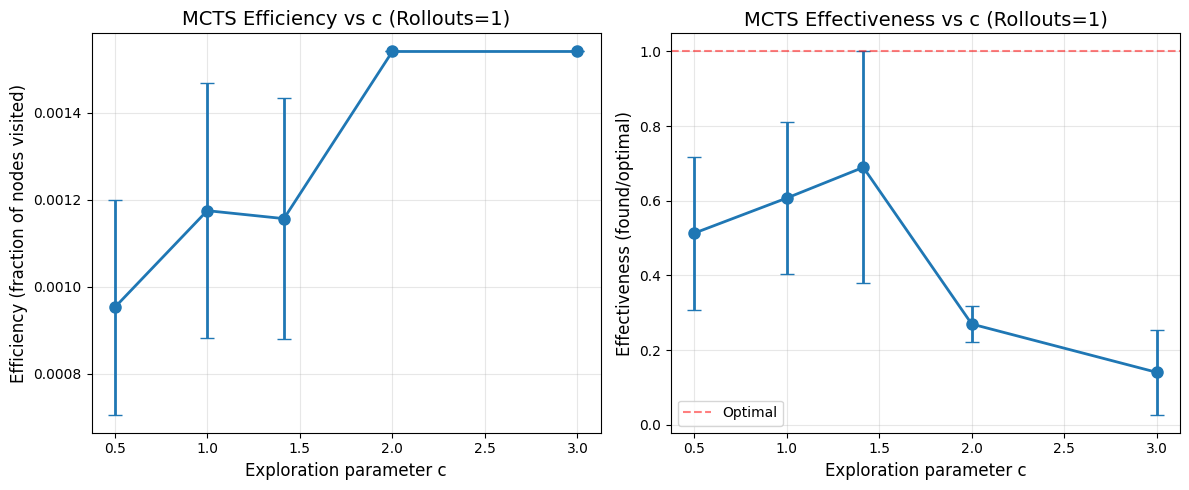

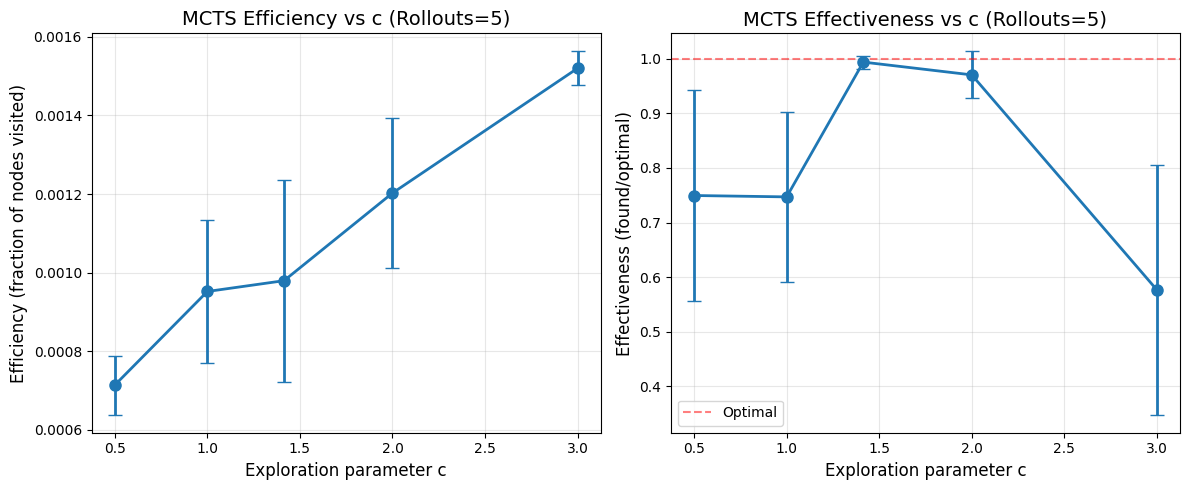

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

class MCTSNode:
    def __init__(self, address):
        self.address = address
        self.visits = 0
        self.total_value = 0
        self.children = {}
        self.parent = None

    def is_leaf(self, depth):
        return len(self.address) == depth

    def ucb_score(self, c, parent_visits):
        if self.visits == 0:
            return float('inf')
        exploitation = self.total_value / self.visits
        exploration = c * np.sqrt(np.log(parent_visits) / self.visits)
        return exploitation + exploration

def edit_distance(addr1, addr2):
    """Count positions where two addresses differ"""
    return sum(a != b for a, b in zip(addr1, addr2))

def compute_leaf_value(address, target_address, B=10, tau=None):
    """Compute value of a leaf node"""
    d = len(address)
    if tau is None:
        tau = d / 5

    dist = edit_distance(address, target_address)
    noise = np.random.randn()
    value = B * np.exp(-dist / tau) + noise
    return value

class MCTS:
    def __init__(self, depth, target_address, B=10, tau=None):
        self.depth = depth
        self.target_address = target_address
        self.B = B
        self.tau = tau if tau else depth / 5
        self.root = MCTSNode("")
        # Pre-compute all leaf values (noise generated once)
        self.leaf_values = {}
        self._generate_leaf_values()
        self.visited_nodes = set()  # Track all visited nodes

    def _generate_leaf_values(self):
        """Generate values for all possible leaf nodes"""
        def generate_all_addresses(d, current=""):
            if d == 0:
                return [current]
            return generate_all_addresses(d-1, current+'L') + generate_all_addresses(d-1, current+'R')

        all_addresses = generate_all_addresses(self.depth)
        for addr in all_addresses:
            self.leaf_values[addr] = compute_leaf_value(addr, self.target_address, self.B, self.tau)

    def get_leaf_value(self, address):
        return self.leaf_values[address]

    def selection(self, c):
        """Select node to expand using UCB"""
        current = self.root
        path = []

        while not current.is_leaf(self.depth):
            path.append(current.address)

            # If not fully expanded, return this node
            if len(current.children) < 2:
                return current

            # Fully expanded, select best child by UCB
            child_L = current.children['L']
            child_R = current.children['R']

            ucb_L = child_L.ucb_score(c, current.visits)
            ucb_R = child_R.ucb_score(c, current.visits)

            if ucb_L > ucb_R:
                current = child_L
            else:
                current = child_R

        return current

    def expansion(self, node):
        """Expand node by adding a child"""
        if node.is_leaf(self.depth):
            return node

        # Add unexplored child
        if 'L' not in node.children:
            child = MCTSNode(node.address + 'L')
            child.parent = node
            node.children['L'] = child
            return child
        elif 'R' not in node.children:
            child = MCTSNode(node.address + 'R')
            child.parent = node
            node.children['R'] = child
            return child

        return node

    def simulation(self, node, num_rollouts=1):
        """Simulate random rollouts from node"""
        if node.is_leaf(self.depth):
            return self.get_leaf_value(node.address)

        total_value = 0
        for _ in range(num_rollouts):
            # Random rollout to a leaf
            current_addr = node.address
            while len(current_addr) < self.depth:
                current_addr += np.random.choice(['L', 'R'])
            total_value += self.get_leaf_value(current_addr)

        return total_value / num_rollouts

    def backpropagation(self, node, value):
        """Backpropagate value up the tree"""
        current = node
        while current is not None:
            current.visits += 1
            current.total_value += value
            self.visited_nodes.add(current.address)  # Track visited
            current = current.parent

    def search(self, num_iterations, c=np.sqrt(2), num_rollouts=1):
        """Run MCTS for given number of iterations"""
        for i in range(num_iterations):
            # Selection
            node = self.selection(c)

            # Expansion
            node = self.expansion(node)

            # Simulation
            value = self.simulation(node, num_rollouts)

            # Backpropagation
            self.backpropagation(node, value)

    def get_best_path(self):
        """Get the path with highest average value"""
        current = self.root
        path = ""

        while not current.is_leaf(self.depth):
            if len(current.children) == 0:
                # No children expanded, complete randomly
                while len(path) < self.depth:
                    path += np.random.choice(['L', 'R'])
                break
            elif len(current.children) == 1:
                # Only one child
                direction = list(current.children.keys())[0]
                path += direction
                current = current.children[direction]
            else:
                # Choose child with highest average value
                child_L = current.children['L']
                child_R = current.children['R']

                avg_L = child_L.total_value / child_L.visits if child_L.visits > 0 else -float('inf')
                avg_R = child_R.total_value / child_R.visits if child_R.visits > 0 else -float('inf')

                if avg_L > avg_R:
                    path += 'L'
                    current = child_L
                else:
                    path += 'R'
                    current = child_R

        return path

    def count_visited_nodes(self):
        """Count how many unique nodes were visited"""
        return len(self.visited_nodes)

    def get_optimal_value(self):
        """Return the actual optimal value (target node value)"""
        return self.get_leaf_value(self.target_address)

    def find_actual_best_leaf(self):
        """Find the actual best leaf by checking all values"""
        best_addr = max(self.leaf_values.keys(), key=lambda k: self.leaf_values[k])
        return best_addr, self.leaf_values[best_addr]


# Experiments
def run_mcts_experiment(depth=20, num_iterations=50, c_values=[0.5, 1.0, np.sqrt(2), 2.0, 3.0],
                        num_rollouts=1, num_trials=10):
    """Run MCTS experiments with different c values"""

    results = {c: {'efficiency': [], 'effectiveness': [], 'visited': [], 'found_value': []}
               for c in c_values}

    for trial in range(num_trials):
        # Generate random target
        target = ''.join(np.random.choice(['L', 'R'], depth))

        print(f"Trial {trial+1}/{num_trials}, Target: {target[:10]}...")

        for c in c_values:
            mcts = MCTS(depth, target)
            best_addr, optimal_value = mcts.find_actual_best_leaf()

            # Run search
            mcts.search(num_iterations, c, num_rollouts)

            # Get results
            best_path = mcts.get_best_path()
            found_value = mcts.get_leaf_value(best_path)
            visited = mcts.count_visited_nodes()
            total_nodes = 2**(depth + 1) - 1

            efficiency = visited / total_nodes
            # Effectiveness relative to actual best (not just target)
            effectiveness = found_value / optimal_value if optimal_value > 0 else 0

            results[c]['efficiency'].append(efficiency)
            results[c]['effectiveness'].append(effectiveness)
            results[c]['visited'].append(visited)
            results[c]['found_value'].append(found_value)

    # Compute averages
    summary = {}
    for c in c_values:
        summary[c] = {
            'avg_efficiency': np.mean(results[c]['efficiency']),
            'std_efficiency': np.std(results[c]['efficiency']),
            'avg_effectiveness': np.mean(results[c]['effectiveness']),
            'std_effectiveness': np.std(results[c]['effectiveness']),
            'avg_visited': np.mean(results[c]['visited']),
        }

    return summary, results

# Run experiments
if __name__ == "__main__":
    print("Running MCTS experiments...")
    print("=" * 60)

    # Experiment 1: Different c values, depth=15, 100 iterations, num_rollouts=1
    print("\n" + "="*60)
    print("Running depth=15, iterations=100, num_rollouts=1 experiment (5 trials)...")
    summary_d15_r1, results_d15_r1 = run_mcts_experiment(depth=15, num_iterations=100, num_trials=5, num_rollouts=1)

    print("\n" + "="*60)
    print("Results for depth=15, iterations=100, num_rollouts=1:")
    print(f"{'c':<10} {'Efficiency':<10} {'Eff. Std':<10} {'Effectiveness':<15} {'Eff. Std':<10} {'Avg Visited':<15}")
    print("-" * 80)
    for c, stats in summary_d15_r1.items():
        print(f"{c:<10.2f} {stats['avg_efficiency']:.6f} {stats['std_efficiency']:.6f} {stats['avg_effectiveness']:.4f} {stats['std_effectiveness']:.4f} {stats['avg_visited']:.1f}")

    # Plot results for num_rollouts=1
    fig_r1, (ax1_r1, ax2_r1) = plt.subplots(1, 2, figsize=(12, 5))

    c_vals = list(summary_d15_r1.keys())
    efficiencies_r1 = [summary_d15_r1[c]['avg_efficiency'] for c in c_vals]
    effectiveness_r1 = [summary_d15_r1[c]['avg_effectiveness'] for c in c_vals]
    eff_stds_r1 = [summary_d15_r1[c]['std_efficiency'] for c in c_vals]
    eff2_stds_r1 = [summary_d15_r1[c]['std_effectiveness'] for c in c_vals]

    ax1_r1.errorbar(c_vals, efficiencies_r1, yerr=eff_stds_r1, marker='o', capsize=5, linewidth=2, markersize=8)
    ax1_r1.set_xlabel('Exploration parameter c', fontsize=12)
    ax1_r1.set_ylabel('Efficiency (fraction of nodes visited)', fontsize=12)
    ax1_r1.set_title('MCTS Efficiency vs c (Rollouts=1)', fontsize=14)
    ax1_r1.grid(True, alpha=0.3)

    ax2_r1.errorbar(c_vals, effectiveness_r1, yerr=eff2_stds_r1, marker='o', capsize=5, linewidth=2, markersize=8)
    ax2_r1.set_xlabel('Exploration parameter c', fontsize=12)
    ax2_r1.set_ylabel('Effectiveness (found/optimal)', fontsize=12)
    ax2_r1.set_title('MCTS Effectiveness vs c (Rollouts=1)', fontsize=14)
    ax2_r1.grid(True, alpha=0.3)
    ax2_r1.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Optimal')
    ax2_r1.legend()

    plt.tight_layout()
    plt.savefig('mcts_results_r1.png', dpi=300, bbox_inches='tight')
    print("\nPlot saved as 'mcts_results_r1.png'")

    # Experiment 2: Different c values, depth=15, 100 iterations, num_rollouts=5
    print("\n" + "="*60)
    print("Running depth=15, iterations=100, num_rollouts=5 experiment (5 trials)...")
    summary_d15_r5, results_d15_r5 = run_mcts_experiment(depth=15, num_iterations=100, num_trials=5, num_rollouts=5)

    print("\n" + "="*60)
    print("Results for depth=15, iterations=100, num_rollouts=5:")
    print(f"{'c':<10} {'Efficiency':<10} {'Eff. Std':<10} {'Effectiveness':<15} {'Eff. Std':<10} {'Avg Visited':<15}")
    print("-" * 80)
    for c, stats in summary_d15_r5.items():
        print(f"{c:<10.2f} {stats['avg_efficiency']:.6f} {stats['std_efficiency']:.6f} {stats['avg_effectiveness']:.4f} {stats['std_effectiveness']:.4f} {stats['avg_visited']:.1f}")

    # Plot results for num_rollouts=5
    fig_r5, (ax1_r5, ax2_r5) = plt.subplots(1, 2, figsize=(12, 5))

    c_vals = list(summary_d15_r5.keys())
    efficiencies_r5 = [summary_d15_r5[c]['avg_efficiency'] for c in c_vals]
    effectiveness_r5 = [summary_d15_r5[c]['avg_effectiveness'] for c in c_vals]
    eff_stds_r5 = [summary_d15_r5[c]['std_efficiency'] for c in c_vals]
    eff2_stds_r5 = [summary_d15_r5[c]['std_effectiveness'] for c in c_vals]

    ax1_r5.errorbar(c_vals, efficiencies_r5, yerr=eff_stds_r5, marker='o', capsize=5, linewidth=2, markersize=8)
    ax1_r5.set_xlabel('Exploration parameter c', fontsize=12)
    ax1_r5.set_ylabel('Efficiency (fraction of nodes visited)', fontsize=12)
    ax1_r5.set_title('MCTS Efficiency vs c (Rollouts=5)', fontsize=14)
    ax1_r5.grid(True, alpha=0.3)

    ax2_r5.errorbar(c_vals, effectiveness_r5, yerr=eff2_stds_r5, marker='o', capsize=5, linewidth=2, markersize=8)
    ax2_r5.set_xlabel('Exploration parameter c', fontsize=12)
    ax2_r5.set_ylabel('Effectiveness (found/optimal)', fontsize=12)
    ax2_r5.set_title('MCTS Effectiveness vs c (Rollouts=5)', fontsize=14)
    ax2_r5.grid(True, alpha=0.3)
    ax2_r5.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Optimal')
    ax2_r5.legend()

    plt.tight_layout()
    plt.savefig('mcts_results_r5.png', dpi=300, bbox_inches='tight')
    print("\nPlot saved as 'mcts_results_r5.png'")


    # Comparison section
    print("\n" + "="*60)
    print("Comparison of num_rollouts=1 vs num_rollouts=5 (depth=15, iterations=100):")
    print("="*60)
    print(f"{'c':<10} {'Eff. R=1':<12} {'Eff. R=5':<12} {'% Change':<10}")
    print("-" * 50)
    for c in c_vals:
        avg_eff_r1 = summary_d15_r1[c]['avg_effectiveness']
        avg_eff_r5 = summary_d15_r5[c]['avg_effectiveness']
        if avg_eff_r1 > 0:
            change_percent = ((avg_eff_r5 - avg_eff_r1) / avg_eff_r1) * 100
        else:
            change_percent = float('inf') # Handle division by zero if r1 effectiveness is 0
        print(f"{c:<10.2f} {avg_eff_r1:.4f}     {avg_eff_r5:.4f}     {change_percent:+.2f}%")

    print("\nNote: Increasing num_rollouts from 1 to 5 is expected to increase computation time by approximately 5x due to more simulations per expansion step.")


    # Also test with depth=20 but fewer trials (this part remains largely the same)
    print("\n" + "="*60)
    print("Running depth=20 experiment (10 trials)...") # Changed trials from 2 to 10
    # MODIFICATION: Increased num_iterations from 50 to 500
    summary20, _ = run_mcts_experiment(depth=20, num_iterations=500, num_trials=10, num_rollouts=1) # Explicitly set num_rollouts=1

    print("\nResults for depth=20, iterations=500, num_rollouts=1:") # Changed title
    print(f"{'c':<10} {'Efficiency':<10} {'Eff. Std':<10} {'Effectiveness':<15} {'Eff. Std':<10} {'Avg Visited':<15}")
    print("-" * 80)
    for c, stats in summary20.items():
        print(f"{c:<10.2f} {stats['avg_efficiency']:.8f} {stats['std_efficiency']:.8f} {stats['avg_effectiveness']:.4f} {stats['std_effectiveness']:.4f} {stats['avg_visited']:.1f}")

MDP EXPERIMENTS

Question 1: Transition matrices and reward vectors
T_R shape: (12, 12)
T_L shape: (12, 12)
r_R shape: (12,)
r_L shape: (12,)

Question 2: Deterministic case (epsilon = 0)
Value iteration converged in 7 iterations

Optimal values:
v*( 0) =   0.00
v*( 1) =   9.00
v*( 2) =   8.00
v*( 3) =   7.00
v*( 4) =   6.00
v*( 5) =   5.00
v*( 6) =   5.00
v*( 7) =   6.00
v*( 8) =   7.00
v*( 9) =   8.00
v*(10) =   9.00
v*(11) =  10.00

Optimal policy:
π*( 1) = L
π*( 2) = L
π*( 3) = L
π*( 4) = L
π*( 5) = L
π*( 6) = R
π*( 7) = R
π*( 8) = R
π*( 9) = R
π*(10) = R
π*(11) = R

Bellman equation satisfied: True

Question 3: Stochastic cases

Epsilon = 0.2
----------------------------------------
Value iteration converged in 40 iterations

Optimal values:
v*( 0) =   0.00
v*( 1) =   8.34
v*( 2) =   6.70
v*( 3) =   5.14
v*( 4) =   3.91
v*( 5) =   4.00
v*( 6) =   5.00
v*( 7) =   6.00
v*( 8) =   7.00
v*( 9) =   8.00
v*(10) =   9.00
v*(11) =  10.00

Optimal policy:
π*( 1) = L
π*( 2) = L
π*( 3) = L
π

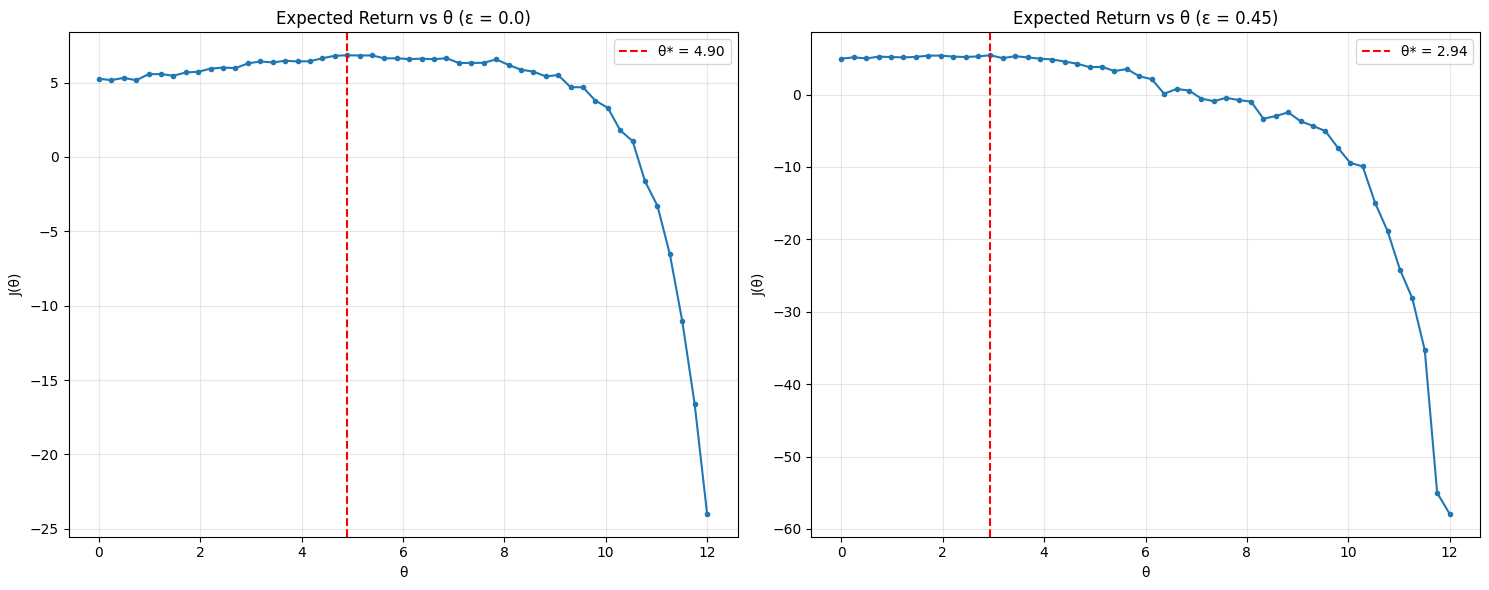

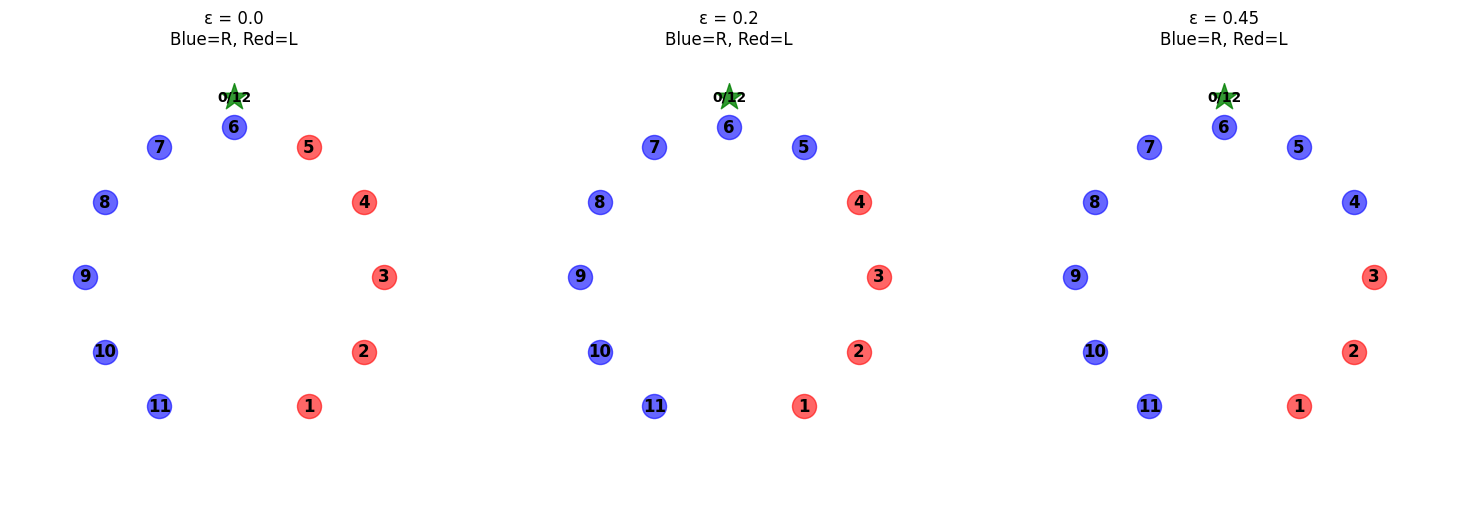

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class ClockMDP:
    def __init__(self, epsilon=0.0, gamma=1.0):
        self.n_states = 12
        self.epsilon = epsilon
        self.gamma = gamma

        # Build transition matrices and reward vectors
        self.T_R, self.r_R = self._build_transition_reward('R')
        self.T_L, self.r_L = self._build_transition_reward('L')

    def _build_transition_reward(self, action):
        """Build transition matrix and reward vector for given action"""
        T = np.zeros((self.n_states, self.n_states))
        r = np.zeros(self.n_states)

        for s in range(self.n_states):
            if s == 0:
                # Absorbing state
                T[s, s] = 1.0
                r[s] = 0.0
            else:
                # Determine next states
                if action == 'R':
                    s_intended = (s + 1) % self.n_states
                    s_opposite = (s - 1) if s > 1 else 11
                else:  # action == 'L'
                    s_intended = (s - 1) if s > 1 else 11
                    s_opposite = (s + 1) % self.n_states

                # Determine probabilities
                if s >= 5:
                    # Deterministic states
                    p_intended = 1.0
                    p_opposite = 0.0
                else:
                    # Stochastic states (1-4)
                    p_intended = 1.0 - self.epsilon
                    p_opposite = self.epsilon

                # Set transition probabilities
                T[s, s_intended] = p_intended
                T[s, s_opposite] = p_opposite

                # Compute expected reward
                r_intended = 10.0 if s_intended == 0 else -1.0
                r_opposite = 10.0 if s_opposite == 0 else -1.0
                r[s] = p_intended * r_intended + p_opposite * r_opposite

        return T, r

    def value_iteration(self, max_iter=1000, tol=1e-6):
        """Solve for optimal value function using value iteration"""
        v = np.zeros(self.n_states)

        for iteration in range(max_iter):
            v_new = np.zeros(self.n_states)

            for s in range(self.n_states):
                if s == 0:
                    v_new[s] = 0.0
                else:
                    # Compute Q-values for both actions
                    q_R = self.r_R[s] + self.gamma * np.dot(self.T_R[s], v)
                    q_L = self.r_L[s] + self.gamma * np.dot(self.T_L[s], v)
                    v_new[s] = max(q_R, q_L)

            # Check convergence
            if np.max(np.abs(v_new - v)) < tol:
                print(f"Value iteration converged in {iteration + 1} iterations")
                break

            v = v_new.copy()

        return v

    def get_optimal_policy(self, v):
        """Extract optimal policy from value function"""
        policy = {}

        for s in range(1, self.n_states):
            q_R = self.r_R[s] + self.gamma * np.dot(self.T_R[s], v)
            q_L = self.r_L[s] + self.gamma * np.dot(self.T_L[s], v)

            policy[s] = 'R' if q_R >= q_L else 'L'

        return policy

    def verify_bellman(self, v):
        """Verify that v satisfies Bellman optimality equation"""
        for s in range(1, self.n_states):
            q_R = self.r_R[s] + self.gamma * np.dot(self.T_R[s], v)
            q_L = self.r_L[s] + self.gamma * np.dot(self.T_L[s], v)
            expected = max(q_R, q_L)

            if abs(v[s] - expected) > 1e-5:
                print(f"State {s}: v={v[s]:.4f}, expected={expected:.4f}")
                return False

        return True


def sigmoid(x):
    """Standard sigmoid function"""
    return 1.0 / (1.0 + np.exp(-x))


class ParametricPolicy:
    def __init__(self, epsilon=0.0):
        self.epsilon = epsilon
        self.n_states = 12

    def get_action_prob(self, state, theta):
        """Get probability of action R given state and parameter theta"""
        return sigmoid(state - theta)

    def sample_action(self, state, theta):
        """Sample action according to parametric policy"""
        prob_R = self.get_action_prob(state, theta)
        return 'R' if np.random.rand() < prob_R else 'L'

    def simulate_trajectory(self, start_state, theta):
        """Simulate one trajectory until reaching absorbing state"""
        state = start_state
        total_reward = 0

        while state != 0:
            action = self.sample_action(state, theta)

            # Execute action with noise
            if state >= 5:
                # Deterministic
                executed_action = action
            else:
                # Stochastic
                if np.random.rand() < self.epsilon:
                    executed_action = 'L' if action == 'R' else 'R'
                else:
                    executed_action = action

            # Transition
            if executed_action == 'R':
                next_state = (state + 1) % 12
            else:
                next_state = (state - 1) if state > 1 else 11

            # Get reward
            reward = 10.0 if next_state == 0 else -1.0
            total_reward += reward

            state = next_state

        return total_reward

    def evaluate_theta(self, theta, num_trajectories=1000):
        """Evaluate expected return for given theta"""
        total_returns = []

        for _ in range(num_trajectories):
            # Random starting state (uniform over 1-11)
            start_state = np.random.randint(1, 12)
            G = self.simulate_trajectory(start_state, theta)
            total_returns.append(G)

        return np.mean(total_returns)

    def find_optimal_theta(self, theta_range=None, num_trajectories=1000):
        """Find optimal theta by grid search"""
        if theta_range is None:
            theta_range = np.linspace(0, 12, 50)

        best_theta = None
        best_J = -float('inf')
        J_values = []

        for theta in theta_range:
            J = self.evaluate_theta(theta, num_trajectories)
            J_values.append(J)

            if J > best_J:
                best_J = J
                best_theta = theta

        return best_theta, best_J, theta_range, J_values


# Main experiments
if __name__ == "__main__":
    print("=" * 60)
    print("MDP EXPERIMENTS")
    print("=" * 60)

    # Question 1: Construct matrices
    print("\nQuestion 1: Transition matrices and reward vectors")
    mdp = ClockMDP(epsilon=0.0)
    print("T_R shape:", mdp.T_R.shape)
    print("T_L shape:", mdp.T_L.shape)
    print("r_R shape:", mdp.r_R.shape)
    print("r_L shape:", mdp.r_L.shape)

    # Question 2: epsilon = 0 (deterministic)
    print("\n" + "=" * 60)
    print("Question 2: Deterministic case (epsilon = 0)")
    print("=" * 60)
    mdp_det = ClockMDP(epsilon=0.0, gamma=1.0)
    v_det = mdp_det.value_iteration()
    policy_det = mdp_det.get_optimal_policy(v_det)

    print("\nOptimal values:")
    for s in range(12):
        print(f"v*({s:2d}) = {v_det[s]:6.2f}")

    print("\nOptimal policy:")
    for s in range(1, 12):
        print(f"π*({s:2d}) = {policy_det[s]}")

    verified = mdp_det.verify_bellman(v_det)
    print(f"\nBellman equation satisfied: {verified}")

    # Question 3: epsilon = 0.2 and 0.45
    print("\n" + "=" * 60)
    print("Question 3: Stochastic cases")
    print("=" * 60)

    for eps in [0.2, 0.45]:
        print(f"\nEpsilon = {eps}")
        print("-" * 40)
        mdp = ClockMDP(epsilon=eps, gamma=1.0)
        v = mdp.value_iteration()
        policy = mdp.get_optimal_policy(v)

        print("\nOptimal values:")
        for s in range(12):
            print(f"v*({s:2d}) = {v[s]:6.2f}")

        print("\nOptimal policy:")
        for s in range(1, 12):
            print(f"π*({s:2d}) = {policy[s]}")

    # Question 4: Parametric policy
    print("\n" + "=" * 60)
    print("Question 4: Parametric policy")
    print("=" * 60)

    fig_param, axes_param = plt.subplots(1, 2, figsize=(15, 6))

    for idx, eps in enumerate([0.0, 0.45]):
        print(f"\nEpsilon = {eps}")
        print("-" * 40)

        pp = ParametricPolicy(epsilon=eps)
        theta_opt, J_opt, theta_range, J_values = pp.find_optimal_theta(num_trajectories=500)

        print(f"Optimal theta: {theta_opt:.2f}")
        print(f"Optimal J: {J_opt:.2f}")

        # Plot on the corresponding subplot
        ax = axes_param[idx]
        ax.plot(theta_range, J_values, marker='o', markersize=3)
        ax.axvline(theta_opt, color='r', linestyle='--', label=f'θ* = {theta_opt:.2f}')
        ax.set_xlabel('θ')
        ax.set_ylabel('J(θ)')
        ax.set_title(f'Expected Return vs θ (ε = {eps})')
        ax.grid(True, alpha=0.3)
        ax.legend()

    plt.tight_layout()
    plt.savefig('parametric_policy_comparison.png', dpi=300)
    print("Plot saved as 'parametric_policy_comparison.png'")

    # Visualization: Compare policies
    print("\n" + "=" * 60)
    print("SUMMARY")
    print("=" * 60)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for idx, eps in enumerate([0.0, 0.2, 0.45]):
        mdp = ClockMDP(epsilon=eps, gamma=1.0)
        v = mdp.value_iteration()
        policy = mdp.get_optimal_policy(v)

        # Plot as clock face
        ax = axes[idx]
        theta = np.linspace(0, 2*np.pi, 12, endpoint=False)
        theta = theta - np.pi/2  # Start at top

        for s in range(1, 12):
            x = np.cos(theta[s])
            y = np.sin(theta[s])

            color = 'blue' if policy[s] == 'R' else 'red'
            ax.scatter(x, y, s=300, c=color, alpha=0.6)
            ax.text(x, y, str(s), ha='center', va='center', fontsize=12, fontweight='bold')

        # Mark absorbing state
        ax.scatter(0, 1.2, s=400, c='green', marker='*', alpha=0.8)
        ax.text(0, 1.2, '0/12', ha='center', va='center', fontsize=10, fontweight='bold')

        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_aspect('equal')
        ax.set_title(f'ε = {eps}\nBlue=R, Red=L')
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('policy_comparison.png', dpi=300)
    print("\nPolicy comparison saved as 'policy_comparison.png'")

In [3]:
import numpy as np

def print_transition_matrix(T, action_name, epsilon):
    """Print transition matrix in readable format"""
    print(f"\nTransition Matrix T_{action_name} (epsilon={epsilon}):")
    print("=" * 80)

    # Print header
    print("From\\To", end="  ")
    for j in range(12):
        print(f"{j:5d}", end="")
    print()
    print("-" * 80)

    # Print each row
    for i in range(12):
        print(f"State {i:2d}", end="  ")
        for j in range(12):
            val = T[i, j]
            if val > 0:
                print(f"{val:5.2f}", end="")
            else:
                print(f"{'.':<5}", end="")
        print()
    print("=" * 80)

def print_reward_vector(r, action_name, epsilon):
    """Print reward vector in readable format"""
    print(f"\nReward Vector r_{action_name} (epsilon={epsilon}):")
    print("-" * 60)
    for i in range(12):
        print(f"State {i:2d}: r = {r[i]:6.2f}")
    print("-" * 60)

    print("\n" + "="*80)
    print("DISPLAYING MATRICES FOR QUESTION 1")
    print("="*80)

    mdp_example = ClockMDP(epsilon=0.2)

    print_transition_matrix(mdp_example.T_R, "R", 0.2)
    print_reward_vector(mdp_example.r_R, "R", 0.2)

    print_transition_matrix(mdp_example.T_L, "L", 0.2)
    print_reward_vector(mdp_example.r_L, "L", 0.2)

    print("\n" + "="*80)
    print("DISPLAYING MATRICES FOR QUESTION 2")
    print("="*80)
